In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import numpy as np
from PIL import Image
from importlib import reload
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime
import wandb
import os
import rawpy
from matplotlib import patches

In [2]:
from models import *
from data_proc import *
from models import *

In [3]:
# prompt: I have 3 folders in my computer (depth with the depth images, rgb with rgb and encoded with encoded images), I want to use them for my path

# Define the base directory containing your data folders
test_dir = r'/bigdata/hadassa/PSFMMDE-Remote/Datasets/vkittiv2_s2'
# Test paths
depth_dir_test = os.path.join(test_dir, 'depths')
rgb_dir_test = os.path.join(test_dir, 'rgbs')
encoded_dir_test = os.path.join(test_dir, 'TPs')

Number of batches: 59
Total samples: 233
Batch size: 4
Encoded image shape: torch.Size([3, 256, 256])
RGB image shape: torch.Size([3, 256, 256])
Depth image shape: torch.Size([1, 256, 256])
0.016876478 1.0
0.0 0.98039216
0.0 0.78431374
0.012466621 1.0
0.0 0.99607843
0.0 0.7647059
0.010910201 1.0
0.0 1.0
0.0 0.77254903
0.008636607 1.0
0.0 0.9764706
0.003921569 0.7254902


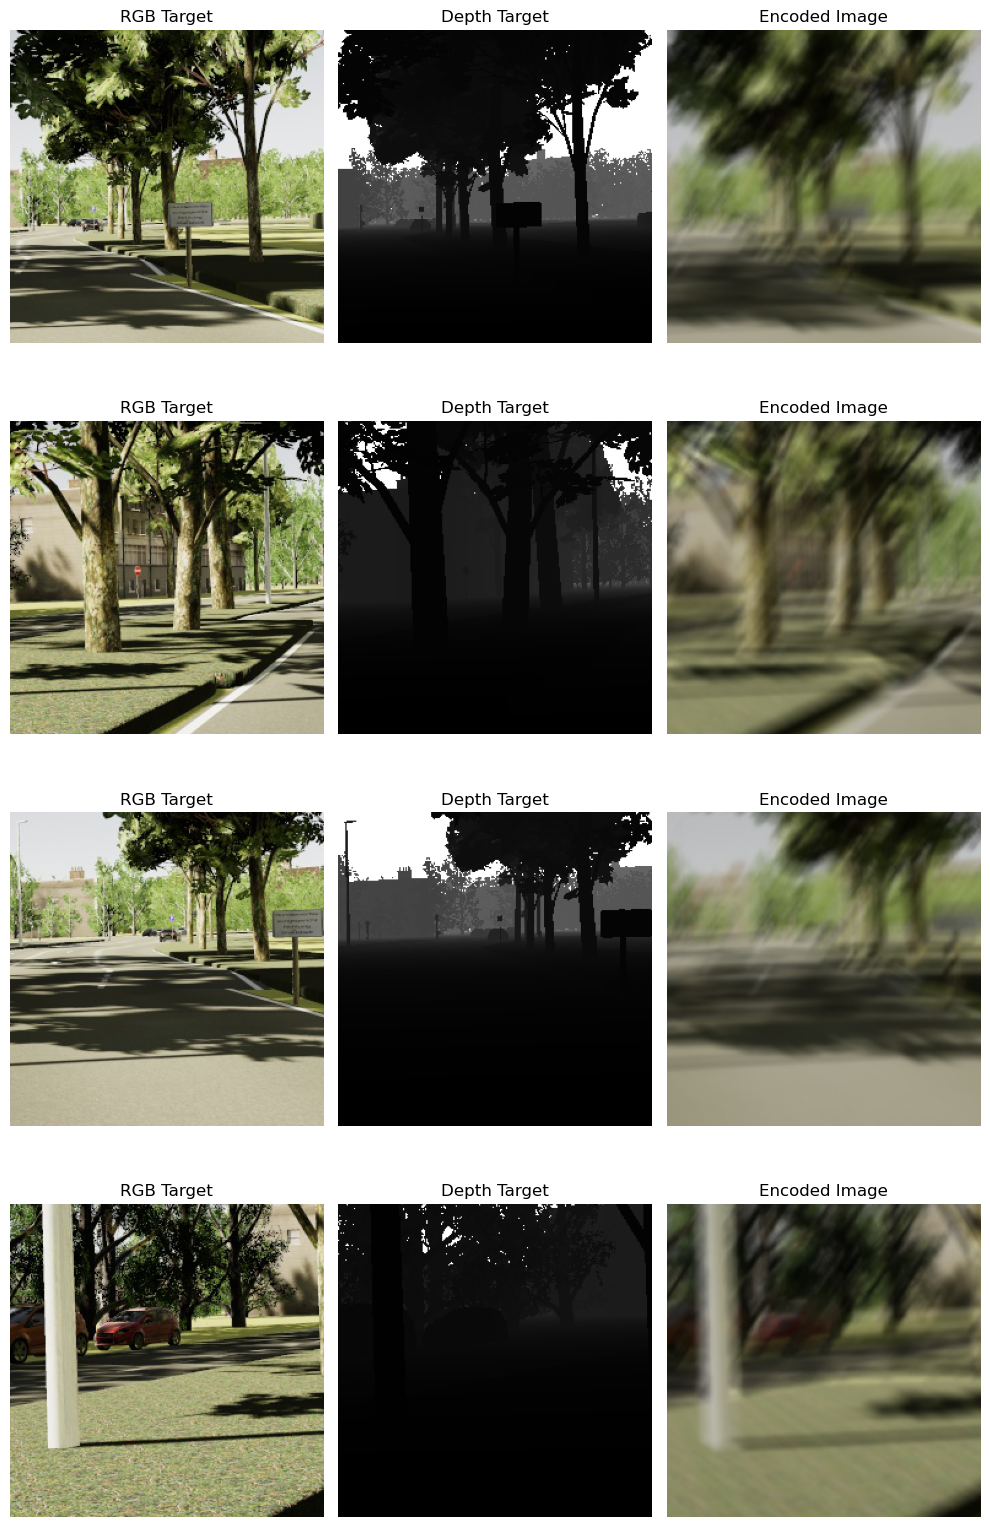

In [4]:
# Get the list of file paths
test_encoded_paths = list_image_files(encoded_dir_test)
test_rgb_paths = list_image_files(rgb_dir_test)
test_depth_paths = list_image_files(depth_dir_test)

# You should add checks here to ensure that the number of files in each directory is the same
if not (len(test_encoded_paths) == len(test_rgb_paths) == len(test_depth_paths)):
    print("Warning: Number of files in depth, rgb, and encoded directories do not match.")
    print(len(test_encoded_paths), len(test_rgb_paths), len(test_depth_paths))
    # You might want to raise an error or handle this discrepancy based on your needs

# Create Datasets and DataLoaders
test_dataset = ImageDataset(test_encoded_paths, test_rgb_paths, test_depth_paths, transform=transform, crop_size=256)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

summarize_data(test_loader, test_dataset)
visualize_data(test_loader)

In [5]:
# del model
# torch.cuda.empty_cache()
from models import *
# Initialize model, loss functions, and optimizer
device = torch.device('cpu') # torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
model = MIMO_UNet().to(device) # MIMOUNet().to(device)

In [6]:
base_dir = r'/bigdata/hadassa/PSFMMDE-Remote/Datasets/vkittiv2'
chpts_dir = os.path.join(base_dir, 'checkpoints')
checkpoint_path = f"{chpts_dir}/model_epoch9900_2025-08-24_00-09-15.pth"
checkpoint = torch.load(checkpoint_path, weights_only=True, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

MIMO_UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, m

In [7]:
def to_numpy_img(tensor):
    """
    Convert a torch tensor (C,H,W) or (H,W,C) in [0,1] to numpy [H,W,3].
    """
    if tensor.ndim == 3 and tensor.shape[0] in [1,3]:
        # (C,H,W)
        tensor = tensor.permute(1,2,0)
    arr = tensor.cpu().numpy()
    arr = np.clip(arr, 0, 1)  # safe for imshow
    return arr

def debug_tensor(name, tensor):
    print(name,
          "shape:", tensor.shape,
          "dtype:", tensor.dtype,
          "min:", tensor.min().item(),
          "max:", tensor.max().item(),
          "unique channels:", [tensor[c].min().item() for c in range(min(3, tensor.shape[0]))])


float32


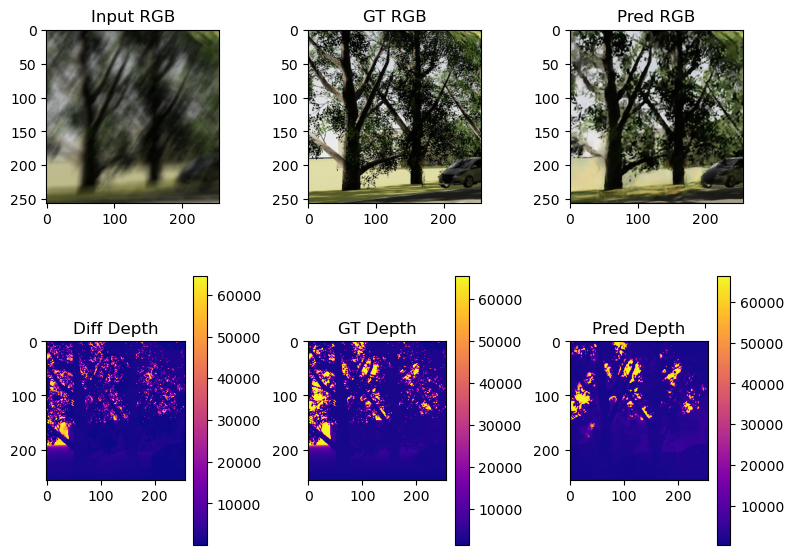

GT RGB shape: torch.Size([3, 256, 256]) dtype: torch.float32 min: 0.0 max: 1.0 unique channels: [0.0, 0.0, 0.0]
Pred RGB shape: torch.Size([3, 256, 256]) dtype: torch.float32 min: -0.00431036576628685 max: 0.9410438537597656 unique channels: [0.0037192092277109623, 0.006968892645090818, -0.00431036576628685]
float32


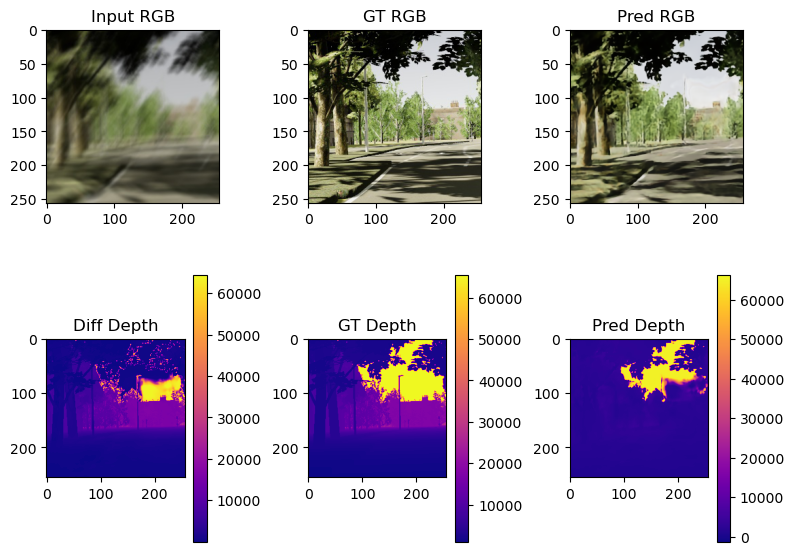

GT RGB shape: torch.Size([3, 256, 256]) dtype: torch.float32 min: 0.0 max: 0.9803921580314636 unique channels: [0.0, 0.0, 0.0]
Pred RGB shape: torch.Size([3, 256, 256]) dtype: torch.float32 min: -0.011558874510228634 max: 0.9374014139175415 unique channels: [-0.002814659383147955, -0.0028353347443044186, -0.011558874510228634]
float32


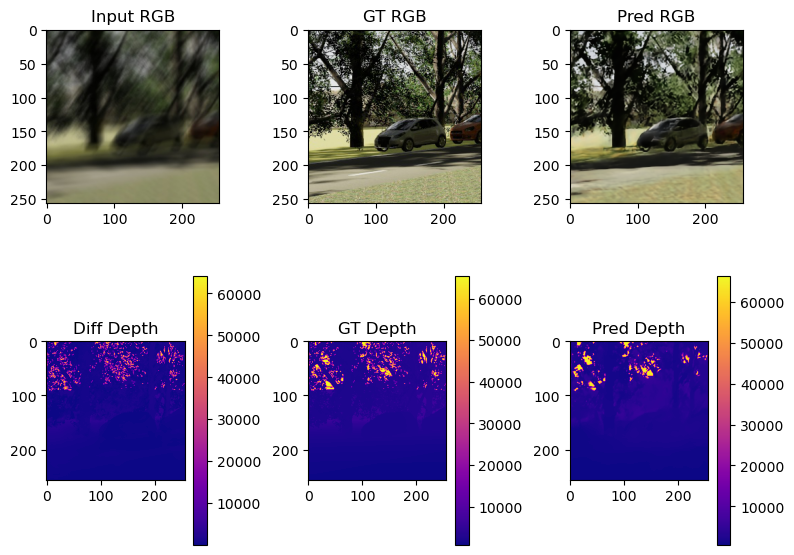

GT RGB shape: torch.Size([3, 256, 256]) dtype: torch.float32 min: 0.0 max: 0.95686274766922 unique channels: [0.0, 0.0, 0.0]
Pred RGB shape: torch.Size([3, 256, 256]) dtype: torch.float32 min: -0.005670638754963875 max: 0.9058019518852234 unique channels: [0.0058553870767354965, 0.008531341329216957, -0.005670638754963875]
Test RGB Loss: 0.0585
Test Depth Loss: 0.0663


In [8]:
test_rgb_loss = 0.0
test_depth_loss = 0.0
# For RGB output (regression on pixel values, typically use L1 or L2)
rgb_criterion = nn.L1Loss()
# For Depth output (regression on pixel values, typically use L1 or L2)
depth_criterion = nn.L1Loss()
plotted = 0; examples_to_plot = 3
with torch.no_grad():
    for encoded_images, rgb_targets, depth_targets in test_loader:
        encoded_images_t = encoded_images.to(device)
        rgb_targets_t = rgb_targets.to(device)
        depth_targets_t = depth_targets.to(device)

        rgb_outputs, depth_outputs = model(encoded_images_t)

        if depth_targets_t.ndim == 4 and depth_targets_t.shape[1] == 1:
             pass
        elif depth_targets_t.ndim == 4 and depth_targets_t.shape[1] == 3:
            depth_targets_t = depth_targets_t[:, :1, :, :] # Take one channel

        loss_rgb = rgb_criterion(rgb_outputs, rgb_targets_t)
        loss_depth = depth_criterion(depth_outputs, depth_targets_t)

        test_rgb_loss += loss_rgb.item() * encoded_images_t.size(0)
        test_depth_loss += loss_depth.item() * encoded_images_t.size(0)

        # ---- Plot a few examples ----
        if plotted < examples_to_plot:
            for i in range(min(encoded_images.size(0), examples_to_plot - plotted)):
                fig, axs = plt.subplots(2, 3, figsize=(8, 6))

                # Convert tensors to numpy images
                input_rgb = to_numpy_img(encoded_images[i])
                pred_rgb = to_numpy_img(rgb_outputs[i])
                true_rgb = to_numpy_img(rgb_targets[i])
                print(true_rgb.dtype)

                pred_depth = depth_outputs[i].cpu().squeeze().numpy()
                true_depth = depth_targets[i].cpu().squeeze().numpy()

                # RGB outputs
                axs[0, 0].imshow(input_rgb); axs[0, 0].set_title("Input RGB")
                axs[0, 1].imshow(true_rgb); axs[0, 1].set_title("GT RGB")
                axs[0, 2].imshow(pred_rgb); axs[0, 2].set_title("Pred RGB")

                # Depth outputs (with colormap)
                a0 = axs[1, 0].imshow(np.abs(true_depth - pred_depth)*65535, cmap="plasma")
                axs[1, 0].set_title("Diff Depth"); fig.colorbar(a0, ax=axs[1, 0])
                a1 = axs[1, 1].imshow(true_depth*65535, cmap="plasma"); axs[1, 1].set_title("GT Depth"); fig.colorbar(a1, ax=axs[1, 1])
                a2 = axs[1, 2].imshow(pred_depth*65535, cmap="plasma"); axs[1, 2].set_title("Pred Depth"); fig.colorbar(a2, ax=axs[1, 2])

                plt.tight_layout(); plt.show()
                debug_tensor("GT RGB", rgb_targets[i].cpu())
                debug_tensor("Pred RGB", rgb_outputs[i].cpu())
                plotted += 1

avg_test_rgb_loss = test_rgb_loss / len(test_dataset)
avg_test_depth_loss = test_depth_loss / len(test_dataset)

print(f'Test RGB Loss: {avg_test_rgb_loss:.4f}')
print(f'Test Depth Loss: {avg_test_depth_loss:.4f}')

In [9]:
# Total parameters
total_params = sum(p.numel() for p in model.parameters())

# Trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(total_params, trainable_params)
# del model
# torch.cuda.empty_cache()

# for i in range(torch.cuda.device_count()):
#     print(f"GPU {i}:")
#     print(f"  Allocated: {torch.cuda.memory_allocated(i)/1024**2:.2f} MB")
#     print(f"  Cached   : {torch.cuda.memory_reserved(i)/1024**2:.2f} MB")


31390916 31390916


In [10]:
folder_exp = r'/bigdata/hadassa/PSFMMDE-Remote/Datasets/TrueImages/CropText'
with torch.no_grad():
    for i, file in enumerate(os.listdir(folder_exp)):
        print(file)
        image = os.path.join(folder_exp, file)
        if image.endswith('.CR2'):
            with rawpy.imread(image) as raw:
                depth = float(image.split('\\')[-1].split('TP_')[-1].split('.')[0].replace('p','.'))
                print(f"Processing {file} #{i} at depth {depth}m")
                raw_data = raw.raw_image_visible
                rgb_data = raw.postprocess(output_bps=8)
                # plt.imshow(rgb_data); plt.show()
                consistent_crop = ConsistentRandomCrop(256)
                input_rgb = Image.fromarray(rgb_data).convert('RGB')
        else:
            rgb_data = Image.open(image).convert('RGB')
            input_rgb = rgb_data
        try:
            crop_input_rgb, crop_params = consistent_crop(input_rgb)
        except:
            continue
        # crop_input_rgb = input_rgb.crop()
        # Normalize or clip if values are not in [0, 1] range
        # input_rgb = np.clip(input_rgb, 0, 1)
        # crop_params = (2500,1000, 2755, 1255)
        # crop_input_rgb = input_rgb.crop(crop_params)
        # Unpack crop_params
        left, top, right, bottom = crop_params
        width = right - left
        height = bottom - top

        # Plot
        fig, ax = plt.subplots()
        ax.imshow(input_rgb)
        rect = patches.Rectangle((left, top), width, height, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        plt.show()

        crop_input_rgb_t = transform(crop_input_rgb).unsqueeze(0).to(device)
        rgb_t, depth_t = model(crop_input_rgb_t)
        depths = depth_t.cpu().squeeze(0).squeeze(0)*65535/100
        mean_depth = torch.mean(depth_t).item()*65535/100
        plt.subplot(1,3,1); plt.imshow(to_numpy_img(crop_input_rgb_t.cpu().squeeze(0))); plt.title(f"{file}")
        plt.subplot(1,3,2); plt.imshow(to_numpy_img(rgb_t.cpu().squeeze(0)));
        plt.subplot(1,3,3); plt.imshow(depths, cmap='plasma');
        plt.title(f'{mean_depth:.2f}m')
        plt.colorbar(); plt.show()
            # break

PS_11p960.jpg
ColoredPoints_07p091.jpg
PS_04p674.jpg
Text_14p273.jpg
Text_09p465.jpg
Text_11p837.jpg
Text_05p778.jpg
ColoredPoints_05p778.jpg
Text_10p583.jpg
Text_08p204.jpg
PS_08p204.jpg
Plant_20p100.jpg
PS_05p778.jpg
ColoredPoints_04p674.jpg
PS_11p837.jpg
Text_13p102.jpg
PS_07p091.jpg
FarText_20p400.jpg
Text_07p091.jpg
PS_19p164.jpg
Text_11p88.jpg
